# NHL Vegas Golden Knights - Retention Redshift Insert
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [1]:
import boto3
import getpass
import pyodbc
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import awswrangler as wr

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [3]:
lkupclientid = 36 # flames
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.info()

(38984, 54)

### We should specify the features used in our model:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 11)
Unseen Data For Predictions: (4172, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [7]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8740,0.9198,0.8961,0.9215,0.9086,0.7059,0.7067,0.3740


### Let's load in our 2021 season data and get retention scores using the model:

In [8]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5369, 11)

In [9]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

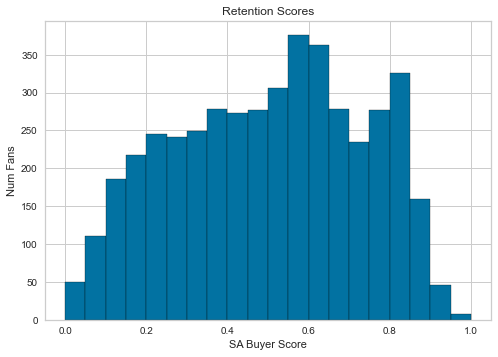

In [87]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [92]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]         8
(0.9, 0.95]        45
(0.85, 0.9]       160
(0.8, 0.85]       326
(0.75, 0.8]       277
(0.7, 0.75]       235
(0.65, 0.7]       278
(0.6, 0.65]       363
(0.55, 0.6]       376
(0.5, 0.55]       306
(0.45, 0.5]       277
(0.4, 0.45]       273
(0.35, 0.4]       279
(0.3, 0.35]       249
(0.25, 0.3]       241
(0.2, 0.25]       246
(0.15, 0.2]       217
(0.1, 0.15]       186
(0.05, 0.1]       111
(-0.001, 0.05]     50
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [89]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

GWWF-JLTR
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using Psycopg2:

In [94]:
try:
    session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
    client = session.client('redshift')

    cluster_creds = client.get_cluster_credentials(                
        DbUser='StellarDataScienceAdmin',
        DbName='stlrflames',
        DbGroups=['admin_group'],
        ClusterIdentifier='qa-app',
        AutoCreate=True
    )
    print("CLUSTER CREDENTIALS RETRIEVED")

except Exception as err:
    print('FAILED TO RETRIEVE CLUSTER CREDS!', err)

CLUSTER CREDENTIALS RETRIEVED


### Insert the new scores into the customerRetentionScores table:

In [110]:
try:

    conn = psycopg2.connect(
        host='qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port=5439,
        user=cluster_creds['DbUser'],
        password=cluster_creds['DbPassword'],
        database='stlrflames'
    )
    print('CREATED CONNECTION TO DATABASE')
    
    cursor = conn.cursor()
    
    fields = f"""
    INSERT INTO dw.customerretentionscores (
        attendancePercentage,
        currversnflag,
        dimcustomermasterid,
        insertdate,
        lkupclientid,
        mostrecentattendance,
        product,
        sascore,
        seasonYear,
        tenuredays
    ) VALUES """

    # Insert Dataframe into SQL Server:
    values_list = []
    for i, (index, row) in enumerate(df_predictions.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(0)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round(row.Score_1,4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""
                        
        values_list.append(values)
    
    insert_statement = fields + ",".join(values_list)+";"
    
    cursor.execute(insert_statement)
    conn.commit()
    
    count = cursor.rowcount
    print(count, "RECORDS INSERTED SUCCESSFULLY")
        
except Exception as err:
    cursor.execute("rollback")
    print("ERROR WHILE INSERTING RETENTION SCORES TO DATABASE:", err)

finally:
    if conn:
        cursor.close()
        conn.close()
        print("REDSHIFT CONNECTION HAS BEEN CLOSED")

CREATED CONNECTION TO DATABASE
4503 RECORDS INSERTED SUCCESSFULLY
REDSHIFT CONNECTION HAS BEEN CLOSED


### Let's query RedShift to make sure our records got into the database:

In [111]:
try:
    conn = psycopg2.connect(
        host='qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port=5439,
        user=cluster_creds['DbUser'],
        password=cluster_creds['DbPassword'],
        database='stlrflames'
    )
    print('CREATED CONNECTION TO DATABASE')
    
    cursor = conn.cursor()
    
    cursor.execute("SELECT COUNT(*) FROM dw.customerretentionscores LIMIT 10;")
    records = cursor.fetchall()
    print(records)

except Exception as err:
    cursor.execute("rollback")
    print("ERROR SELECTING RETENTION SCORES FROM DATABASE:", err)
    
finally:
    if conn:
        cursor.close()
        conn.close()
        print("REDSHIFT CONNECTION HAS BEEN CLOSED")

CREATED CONNECTION TO DATABASE
[(4523,)]
REDSHIFT CONNECTION HAS BEEN CLOSED


### Delete records from DB (for testing):

In [103]:
try:
    conn = psycopg2.connect(
        host='qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port=5439,
        user=cluster_creds['DbUser'],
        password=cluster_creds['DbPassword'],
        database='stlrflames'
    )
    print('CREATED CONNECTION TO DATABASE')
    
    cursor = conn.cursor()
    
    delete_query = """DELETE FROM dw.customerretentionscores where currversnflag = false"""
    
    cursor.execute(delete_query)
    conn.commit()

    count = cursor.rowcount
    print(count, "RECORDS DELETED SUCCESSFULLY")
    
except Exception as err:
    cursor.execute("rollback")
    print("ERROR DELETING RETENTION SCORES TO DATABASE:", err)

finally:
    if conn:
        cursor.close()
        conn.close()
        print("REDSHIFT CONNECTION HAS BEEN CLOSED")

CREATED CONNECTION TO DATABASE
29063 RECORDS DELETED SUCCESSFULLY
REDSHIFT CONNECTION HAS BEEN CLOSED
